# Dataset: Amazon Customer Review

## Descripcion

El conjunto de datos contiene el texto de revisión del cliente con los metadatos que lo acompañan, que consta de tres componentes principales:

*   Una colección de reseñas escritas en el mercado Amazon.com y metadatos asociados desde 1995 hasta 2015. Esto está destinado a facilitar el estudio de las propiedades (y la evolución) de las opiniones de los clientes, incluyendo potencialmente cómo las personas evalúan y expresan sus experiencias con respecto a los productos a escala. (130M+ opiniones de clientes)


*   Una colección de reseñas sobre productos en varios idiomas de diferentes mercados de Amazon, destinada a facilitar el análisis de la percepción de los clientes de los mismos productos y las preferencias más amplias de los consumidores en todos los idiomas y países. (Más de 200K opiniones de clientes en 5 países)


*   Una colección de reseñas que han sido identificadas como no conformes con respecto a las políticas de Amazon. Esto tiene la intención de proporcionar un conjunto de datos de referencia para la investigación sobre la detección de revisiones promocionales o sesgadas. (varios miles de comentarios de clientes). Esta parte del conjunto de datos se distribuye por separado y está disponible previa solicitud; comuníquese con la dirección de correo electrónico a continuación si está interesado en obtener este conjunto de datos.

## Source

Link: https://s3.amazonaws.com/amazon-reviews-pds/readme.html

File used: https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz

Los archivos son del formato .tsv, que significa "*tab separated values*".

Recomiendo abrir este tipo de archivo en Excel, y luego convertirlo a un .txt o .csv

# Dependencias

In [106]:
#!pip install nltk
#!pip install sklearn
#!pip install wordcloud
#!pip install imblearn
#!pip install seaborn

In [105]:
import re
import string

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    matthews_corrcoef,
)
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.svm import LinearSVC
from wordcloud import WordCloud

# Limpieza y Transformacion de Datos

In [3]:
data = pd.read_csv(
    "amazon_reviews_us_Electronics_v1_00.csv",
    usecols=["star_rating", "review_headline", "review_body"],
)

In [4]:
print("Shape - 100% of the data:", data.shape)

Shape - 100% of the data: (1048575, 3)


In [5]:
data = data.sample(frac=0.20, replace=True, random_state=1, ignore_index=True)

In [6]:
print("Shape - 20% Random sample of the data:", data.shape)

Shape - 20% Random sample of the data: (209715, 3)


In [7]:
data.head()

,star_rating,review_headline,review_body
0,5.0,Battery life is excellent. Pairs with my phone...,Battery life is excellent. Pairs with my phon...
1,4.0,"Good, but.","Good sound quality, but occasional fuzzy inter..."
2,1.0,"These over priced, poor quality headphones don...",My wife bought me these headphones on Amazon o...
3,5.0,pretty great.,It's an HDMI cable. It conducts HDMI signals f...
4,4.0,Four Stars,its somewhat ok not easy to use


Dado que las columnas review_headline y review_body son relacionadas y ambas poseen texto, podemos unificarlas en una sola columna llamada review

In [8]:
data["review"] = data["review_headline"] + " " + data["review_body"]

In [9]:
# borramos las columnas individuales
data = data.drop(columns=["review_headline", "review_body"])

In [10]:
# reordenamos las columnas
features = "review"
target = "star_rating"
data = data[[features, target]]
data.head()

,review,star_rating
0,Battery life is excellent. Pairs with my phone...,5.0
1,"Good, but. Good sound quality, but occasional ...",4.0
2,"These over priced, poor quality headphones don...",1.0
3,pretty great. It's an HDMI cable. It conducts ...,5.0
4,Four Stars its somewhat ok not easy to use,4.0


In [11]:
data.describe(include="object")

,review
count,209682
unique,173029
top,Five Stars Great
freq,552


OPCIONAL: Borramos reviews duplicados

Este paso es opcional dado que igual vamos a tener registros duplicados por el over sampling (tecnica para corregir data desbalanceada).

In [12]:
data = data.drop_duplicates(subset=[features])

In [13]:
data.describe(include="object")

,review
count,173029
unique,173029
top,Battery life is excellent. Pairs with my phone...
freq,1


In [14]:
data.describe()

,star_rating
count,173030.000000
mean,4.054493
std,1.395862
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [15]:
data[target].value_counts()

5.0    102927
4.0     26924
1.0     20293
3.0     13153
2.0      9733
Name: star_rating, dtype: int64

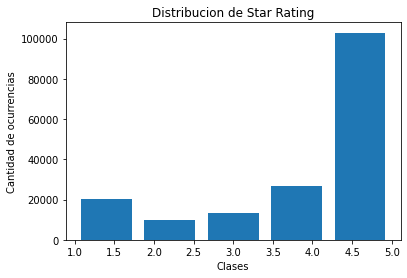

['1 : 20293', '2 : 9733', '3 : 13153', '4 : 26924', '5 : 102927']


In [171]:
min_star = int(data[target].min())
max_star = int(data[target].max())
num_reviews = data[target].nunique()
labels = [
    f"{i} : {data[target].loc[data[target] == i].count()}"
    for i in range(min_star, max_star + 1)
]
plt.hist(data[target], bins=num_reviews, rwidth=0.8, label=[labels])
plt.xlabel("Clases")
plt.ylabel("Cantidad de ocurrencias")
plt.title("Distribucion de Star Rating")
plt.show()
print(labels)

Tenemos un problema de data desbalanceada, pero antes de balancearla debemos limpear el texto de la columna review

*Porque remover Unicode?*

ASCII formats emojis and other non-ASCII characters as Unicode. Essentially, Unicode is a universal character encoding standard in which each character and symbol in all languages are assigned a code. Unicode is required because it is the only encoding standard that allows us to retrieve or join data using a variety of different languages but the issue is… It’s unreadable in ASCII format.

In [17]:
# correr una sola vez
# nltk.download("stopwords")

In [18]:
stop_words = set(stopwords.words("english"))
re_patterns = [
    r"#",  # quita hashtag
    r"\$",  # quita simbolo de dolar
    r"@\S+",  # quita menciones... ejemplo: @Apple
    r"[0-9]+",  # quita numeros
    r"[^\w\s]",  # quita puntuacion
    r"https?:\/\/.*[\r\n]*",  # quita urls
]
unified_pattern = "|".join([f"({pattern})" for pattern in re_patterns])


def cleanText(text):
    # me aseguro de que la entrada sea de typo str
    text = str(text)
    # convierto todo a minuscula
    text = text.lower()
    # remuevo los '_'
    text = text.replace("_", " ")
    # remuevo todo patron de caracteres innecesario con regex
    text = re.sub(unified_pattern, "", text)
    # remuevo caractares no ASCII
    text = text.encode(encoding="ascii", errors="ignore").decode()
    # remuevo palabras innecesarias
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

In [19]:
data[features] = data[features].map(lambda x: cleanText(x))

In [20]:
data.head()

,review,star_rating
0,battery life excellent pairs phone tablet easi...,5.0
1,good good sound quality occasional fuzzy inter...,4.0
2,priced poor quality headphones dont even deser...,1.0
3,pretty great hdmi cable conducts hdmi signals ...,5.0
4,four stars somewhat ok easy use,4.0


*Que es Stemming y Lemmatization?*
* Stemming:
In linguistic morphology and information retrieval, stemming is the process of reducing inflected words to their word stem, base, or root form — generally a written word form.
* Lemmatization: 
Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be analyzed as a single item, identified by the word’s lemma, or dictionary form.

In [21]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def textStemming(text):
    # me aseguro de que la entrada sea de typo str
    text = str(text)
    # normalizo las palabras usando Stemming o Lemmatization, en este caso usare stemming
    text = " ".join([stemmer.stem(word) for word in text.split()])

    return text


def textLemmatization(text):
    # me aseguro de que la entrada sea de typo str
    text = str(text)
    # normalizo las palabras usando Stemming o Lemmatization, en este caso usare stemming
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

In [22]:
data[features] = data[features].map(lambda x: textStemming(x))

Dataset con palabras normalizadas, ahora toca convertirlo a una matriz documento-terminos.

In [23]:
data.head()

,review,star_rating
0,batteri life excel pair phone tablet easili ba...,5.0
1,good good sound qualiti occasion fuzzi interfe...,4.0
2,price poor qualiti headphon dont even deserv s...,1.0
3,pretti great hdmi cabl conduct hdmi signal dev...,5.0
4,four star somewhat ok easi use,4.0


In [24]:
data.shape

(173030, 2)

In [25]:
# guardo el dataframe como csv para optimizar tiempos de ejecucion
data.to_csv("stemmed_data_s0.2_amazon_reviews_us_Electronics_v1_00.csv", index=False)

In [26]:
# -- Checkpoint --
# Cargamos stemmed data
# data = pd.read_csv('stemmed_data_s0.2_amazon_reviews_us_Electronics_v1_00.csv')
# features = 'review'
# target = 'star_rating'

*Que es TFID?*
TF-IDF stands for “Term Frequency — Inverse Data Frequency”.
* Term Frequency (tf):
gives us the frequency of the word in each document in the corpus. It is the ratio of number of times the word appears in a document compared to the total number of words in that document. It increases as the number of occurrences of that word within the document increases. Each document has its own tf.
* Inverse Data Frequency (idf): 
used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score. It is given by the equation below.

Combining these two we come up with the TF-IDF score (w) for a word in a document in the corpus. It is the product of tf and idf.

In [27]:
vectorizer = TfidfVectorizer(max_features=100000)
doc_term_matrix = vectorizer.fit_transform(data[features].astype("U").values)

Truncamos el vectorizer a solo 100000 caracteristicas por limitaciones de memoria.

In [28]:
print("Document-Term Matrix shape:", doc_term_matrix.shape)

Document-Term Matrix shape: (173030, 62393)


In [29]:
print("Document-Term Features shape:", vectorizer.get_feature_names_out().shape)

Document-Term Features shape: (62393,)


In [30]:
doc_term_matrix_cols = vectorizer.get_feature_names_out().tolist()

In [31]:
doc_term_matrix = pd.DataFrame.sparse.from_spmatrix(
    doc_term_matrix, columns=doc_term_matrix_cols
)

In [32]:
# sumamos los valores por columnas para delimitar las caractersiticas mas relevantes
max_features = 15000
top_features = (
    doc_term_matrix.sum().sort_values(ascending=False).index.tolist()[:max_features]
)

In [33]:
doc_term_matrix = doc_term_matrix[top_features]

In [34]:
doc_term_matrix.head()

,star,five,great,work,good,sound,product,one,price,use,...,powerfool,reunion,boseawesom,laptopcomput,een,performavc,comtrol,sooooooo,desnt,phil
0,0.000000,0.0,0.078611,0.000000,0.000000,0.000000,0.109684,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.000000,0.344172,0.170667,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.095948,0.0,0.049750,0.096098,0.000000,0.000000,0.069415,0.0,0.138611,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.192372,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.201862,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.252538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
doc_term_matrix.shape

(173030, 15000)

In [36]:
# debe realizarse a traves de un pipeline o con una menor cantidad de datos por que consume mucha memoria
# doc_term_matrix = doc_term_matrix.sparse.to_dense()

In [38]:
data = data.reset_index(drop=True)
doc_term_matrix = doc_term_matrix.reset_index(drop=True)
dtm_with_target = pd.concat([doc_term_matrix, data[target]], axis=1).reset_index(
    drop=True
)

In [39]:
dtm_with_target.head()

,star,five,great,work,good,sound,product,one,price,use,...,reunion,boseawesom,laptopcomput,een,performavc,comtrol,sooooooo,desnt,phil,star_rating
0,0.000000,0.0,0.078611,0.000000,0.000000,0.000000,0.109684,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,0.000000,0.0,0.000000,0.000000,0.344172,0.170667,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.095948,0.0,0.049750,0.096098,0.000000,0.000000,0.069415,0.0,0.138611,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.0,0.192372,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,0.201862,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.252538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [40]:
dtm_with_target.shape

(173030, 15001)

Ahora ya tenemos un dataset en formato doc_term_matrix con la columna star_rating

In [41]:
# guardo el dataframe como csv para optimizar tiempos de ejecucion
# dtm_with_target.to_csv('dtm_s0.2_c12500_amazon_reviews_us_Electronics_v1_00.csv', index=False)

# Analisis Exploratorio

* Cuales son las palabras mas usadas por rating (clase)?
* Cual es el vocabulario (palabras unicas) de cada rating (clase)?

In [42]:
groupby_df = dtm_with_target.groupby([target]).sum()

In [84]:
# guardo el dataframe como csv para optimizar tiempos de ejecucion
groupby_df.to_csv("grouped_dtm_s0.2_c15000_amazon_reviews_us_Electronics_v1_00.csv")

In [44]:
groupby_df.head()

,star,five,great,work,good,sound,product,one,price,use,...,powerfool,reunion,boseawesom,laptopcomput,een,performavc,comtrol,sooooooo,desnt,phil
star_rating,,,,,,,,,,,,,,,,,,,,,
1.0,1141.486189,10.637786,118.980597,1256.202267,252.829452,348.506128,449.768953,1898.384030,64.276840,432.219605,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.427691,0.901592,0.197869
2.0,461.210337,5.553932,123.253640,428.001806,224.906320,325.618478,137.260950,207.110231,73.546063,239.503117,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.782831,0.254466,0.000000,0.000000
3.0,726.616263,5.774898,243.910373,553.490330,501.409967,461.219344,173.936189,261.228206,225.799502,311.208928,...,0.000000,0.000000,0.00000,0.000000,0.655124,0.000000,0.000000,0.000000,0.000000,0.000000
4.0,1828.267285,19.211233,1193.196202,1336.238156,1655.904999,1046.360076,546.738522,414.804766,759.747925,676.398653,...,0.000000,0.516862,0.00000,0.000000,0.000000,0.000000,0.118958,0.000000,0.000000,0.414542
5.0,7902.087668,9682.239066,7579.095689,5235.488403,3953.071180,3495.188113,3052.722102,1485.113846,3005.151476,2350.377855,...,0.902094,0.385135,0.90192,0.901882,0.246706,0.901823,0.000000,0.219465,0.000000,0.289136


In [45]:
# generamos diccionario de las 50 palabras mas relevantes por review
max_words = 50
review_top_words_dict = {}
for index in groupby_df.index:
    review_top_words_dict[index] = (
        groupby_df.sort_values(by=index, axis=1, ascending=False)
        .iloc[int(index - 1)]
        .head(max_words)
        .to_dict()
    )

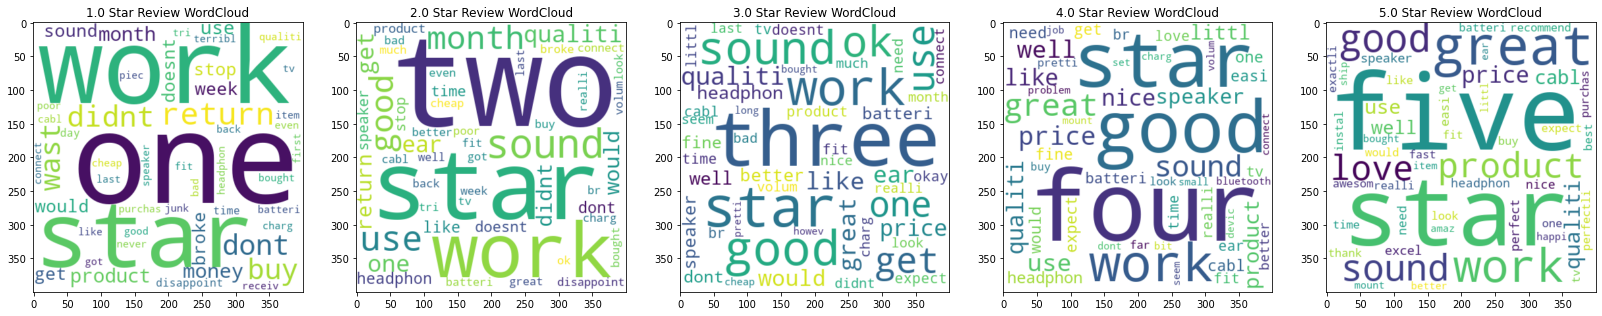

In [46]:
# generamos word cloud de las 50 palabras mas relevantes por review
fig_rows = 1
fig_cols = 5
f, ax = plt.subplots(fig_rows, fig_cols, figsize=(28, 28))

for i, key in enumerate(review_top_words_dict.keys()):
    wordcloud = WordCloud(
        height=400, background_color="white"
    ).generate_from_frequencies(review_top_words_dict[key])
    ax[i].imshow(wordcloud, interpolation="bilinear")
    ax[i].set_title(f"{key} Star Review WordCloud")

In [47]:
# unifico todo las palabras en una sola lista
review_top_words_list = []
for key in review_top_words_dict.keys():
    review_top_words_list += review_top_words_dict[key].keys()

# genero una lista de palabras unicas (no repetidas)
uniques = set()
duplicates = set()
for word in review_top_words_list:
    if word in duplicates:
        continue
    if word in uniques:
        uniques.remove(word)
        duplicates.add(word)
    else:
        uniques.add(word)

# asigno cada palabra unica a su review correspondiente dentro de una lista
review_unique_top_words_list = list(uniques)
review_unique_top_words_dict = {}
for key in review_top_words_dict.keys():
    words = []
    for word in review_unique_top_words_list:
        if word in review_top_words_dict[key].keys():
            words.append(word)
    review_unique_top_words_dict[key] = words

In [48]:
# mostramos vocabulario para cada review
for key in review_unique_top_words_dict.keys():
    print(
        f"{key} star review Vocabulary | # Items: {len(review_unique_top_words_dict[key])} | Items: {review_unique_top_words_dict[key]}"
    )

1.0 star review Vocabulary | # Items: 9 | Items: ['money', 'never', 'piec', 'day', 'receiv', 'junk', 'first', 'wast', 'terribl']
2.0 star review Vocabulary | # Items: 1 | Items: ['two']
3.0 star review Vocabulary | # Items: 4 | Items: ['howev', 'long', 'three', 'okay']
4.0 star review Vocabulary | # Items: 9 | Items: ['devic', 'small', 'far', 'job', 'bluetooth', 'four', 'set', 'problem', 'bit']
5.0 star review Vocabulary | # Items: 14 | Items: ['exactli', 'recommend', 'ship', 'perfect', 'perfectli', 'happi', 'awesom', 'five', 'best', 'fast', 'amaz', 'excel', 'thank', 'instal']


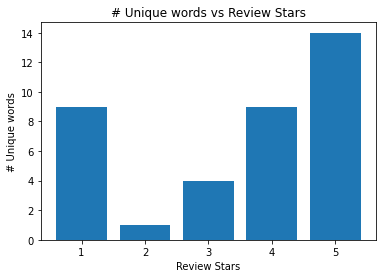

In [49]:
# mostramos cantidad de palabros por vocabulario en cada review
review_unique_words_count = []
for key in review_unique_top_words_dict.keys():
    review_unique_words_count.append(len(review_unique_top_words_dict[key]))

plt.bar(review_unique_top_words_dict.keys(), review_unique_words_count)
plt.xlabel("Review Stars")
plt.ylabel("# Unique words")
plt.title("# Unique words vs Review Stars")
plt.show()

# Entrenamiento del Modelo

In [50]:
X = dtm_with_target.drop(columns=[target])
y = dtm_with_target[target]

In [51]:
# data no balanceada
X.shape, y.shape

((173030, 15000), (173030,))

In [52]:
# data no balanceada
y.value_counts()

5.0    102927
4.0     26924
1.0     20293
3.0     13153
2.0      9733
Name: star_rating, dtype: int64

In [53]:
# oversampling para balancear las clases
# over_sampler = SMOTE()
# X_bal, y_bal = over_sampler.fit_resample(X.to_numpy(), y.to_numpy())

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
clf = LinearSVC(random_state=1, tol=1e-5)
clf.fit(X_train, y_train)

LinearSVC(random_state=1, tol=1e-05)

# Evaluacion

In [92]:
kf = KFold(n_splits=5)

scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring="accuracy")
print(f"Cross_validation Metrics - LinearSVC:", scores)
print(f"Cross_validation Mean - LinearSVC:", scores.mean())

Cross_validation Metrics - LinearSVC: [0.77457107 0.78183132 0.77590753 0.77905003 0.77976448]
Cross_validation Mean - LinearSVC: 0.7782248854215995


In [102]:
y_pred = clf.predict(X_test)

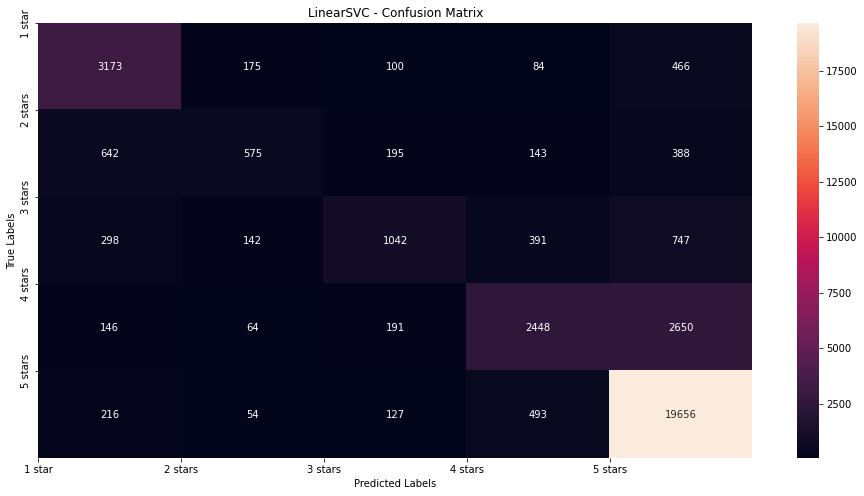

In [117]:
plt.figure(figsize=(16, 8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt="")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(
    ticks=range(5), labels=["1 star", "2 stars", "3 stars", "4 stars", "5 stars"]
)
plt.yticks(
    ticks=range(5), labels=["1 star", "2 stars", "3 stars", "4 stars", "5 stars"]
)
plt.title("LinearSVC - Confusion Matrix")
plt.show()

In [100]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

   1 : 20293       0.71      0.79      0.75      3998
    2 : 9733       0.57      0.30      0.39      1943
   3 : 13153       0.63      0.40      0.49      2620
   4 : 26924       0.69      0.45      0.54      5499
  5 : 102927       0.82      0.96      0.88     20546

    accuracy                           0.78     34606
   macro avg       0.68      0.58      0.61     34606
weighted avg       0.76      0.78      0.76     34606



Precision answers the question of “what proportion of predicted positives are truly positive?”

Recall answers the question of “what proportion of actual positives are correctly classified?”

Due to their nature, precision and recall are in a trade-off relationship. You may have to optimize one at the cost of the other. This is where the F1 score comes in. It is calculated by taking the harmonic mean of precision and recall and ranges from 0 to 1. The harmonic mean has a nice arithmetic property representing a truly balanced mean.

In [101]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7771484713633474


*Que es Cohen Kappa?*

In simple words, Cohen Kappa tells you how much better is your model over the random classifier that predicts based on class frequencies.

In [97]:
print("Cohen Kappa Metric:", cohen_kappa_score(y_test, y_pred))

Cohen Kappa Metric: 0.5972339037906819


*Que es Matthews Correlation Coefficient MCC?*

It’s a correlation between predicted classes and ground truth. It can be calculated based on values from the confusion matrix.

In [99]:
print("Matthews Correlation Coefficient MCC Metric:", matthews_corrcoef(y_test, y_pred))

Matthews Correlation Coefficient MCC Metric: 0.6079991160689276


# Insights

*Una review con mayor cantidad de caracteres ayudara al modelo a entender mejor el contexto y clasificarlo con menos errores?*

In [140]:
insights_cols = [
    "clean_review",
    "real_star_rating",
    "pred_star_rating",
    "review_length",
    "review_word_count",
]

insights_df = pd.DataFrame(columns=insights_cols)
insights_df["clean_review"] = data[features].iloc[X_test.index]
insights_df["real_star_rating"] = y_test
insights_df["pred_star_rating"] = y_pred
insights_df["review_length"] = insights_df["clean_review"].map(lambda x: len(x))
insights_df["review_word_count"] = insights_df["clean_review"].map(
    lambda x: len(x.split(" "))
)

In [157]:
insights_df.head()

,clean_review,real_star_rating,pred_star_rating,review_length,review_word_count,correct_pred
70474,fortun ahvent seriou weather tri radio arriv q...,4.0,1.0,102,16,0
108606,minor fault remot control could use better cas...,5.0,4.0,244,39,0
38252,five star exactli like origin one came directv...,5.0,5.0,58,10,1
137998,smart meter want instal top qualitygerman made...,5.0,5.0,665,108,1
31745,problem problemswil order need,5.0,5.0,30,4,1


In [145]:
insights_df["correct_pred"] = 0
insights_df.loc[
    insights_df["real_star_rating"] == insights_df["pred_star_rating"], "correct_pred"
] = 1

In [158]:
insights_df.head()

,clean_review,real_star_rating,pred_star_rating,review_length,review_word_count,correct_pred
70474,fortun ahvent seriou weather tri radio arriv q...,4.0,1.0,102,16,0
108606,minor fault remot control could use better cas...,5.0,4.0,244,39,0
38252,five star exactli like origin one came directv...,5.0,5.0,58,10,1
137998,smart meter want instal top qualitygerman made...,5.0,5.0,665,108,1
31745,problem problemswil order need,5.0,5.0,30,4,1


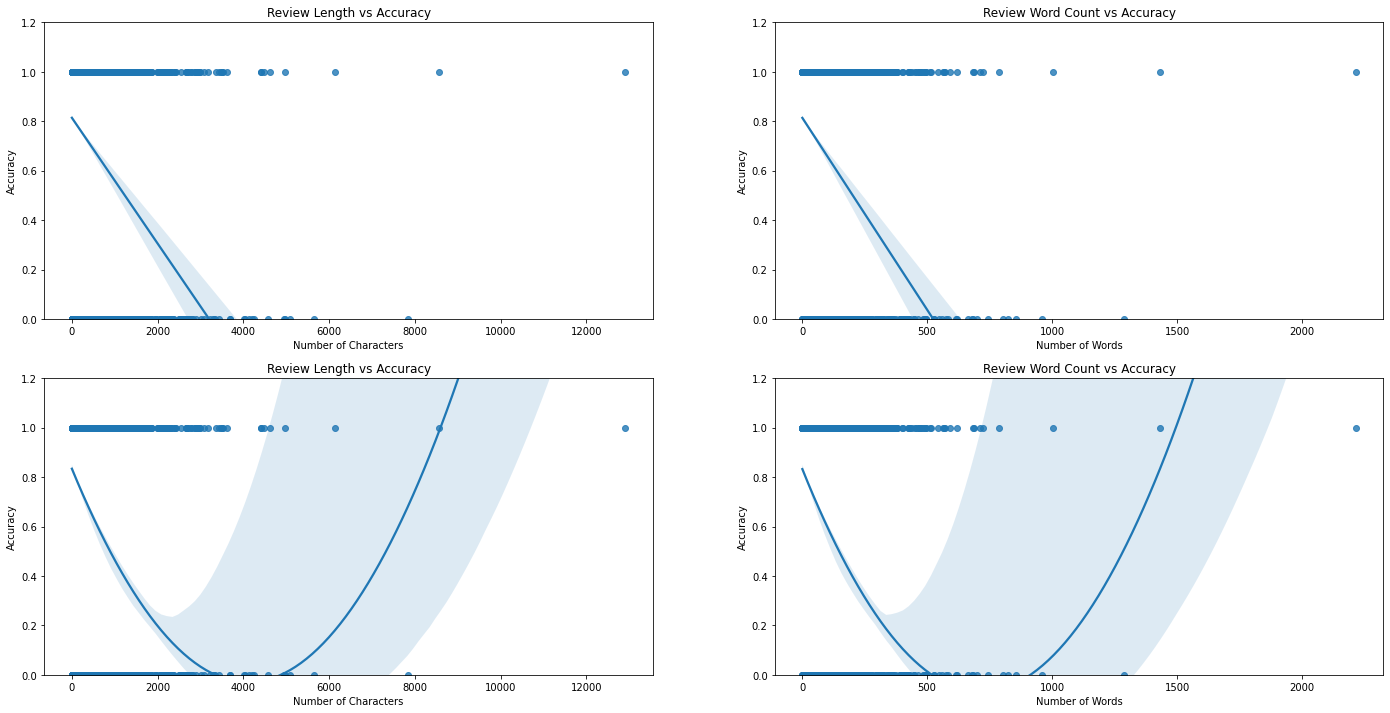

In [170]:
order = 1
fig_rows = 2
fig_cols = 2
f, ax = plt.subplots(fig_rows, fig_cols, figsize=(24, 12))


for row in range(fig_rows):
    sns.regplot(
        x="review_length",
        y="correct_pred",
        data=insights_df,
        ax=ax[row][0],
        order=order,
    )
    ax[row][0].set_ylim(bottom=0, top=1.2)
    ax[row][0].set_title("Review Length vs Accuracy")
    ax[row][0].set_xlabel("Number of Characters")
    ax[row][0].set_ylabel("Accuracy")

    sns.regplot(
        x="review_word_count",
        y="correct_pred",
        data=insights_df,
        ax=ax[row][1],
        order=order,
    )
    ax[row][1].set_ylim(bottom=0, top=1.2)
    ax[row][1].set_title("Review Word Count vs Accuracy")
    ax[row][1].set_xlabel("Number of Words")
    ax[row][1].set_ylabel("Accuracy")

    order += 1

plt.show()

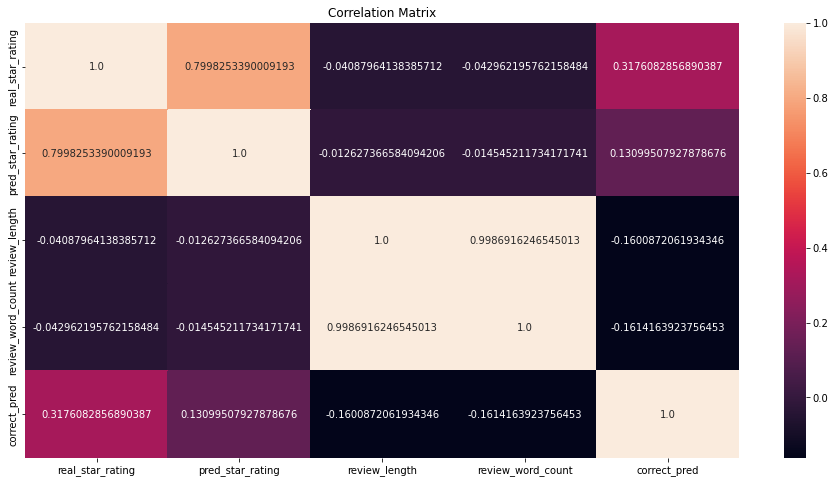

In [156]:
plt.figure(figsize=(16, 8))
sns.heatmap(insights_df.corr(), annot=True, fmt="")
plt.title("Correlation Matrix")
plt.show()

In [153]:
insights_df.corr()

,real_star_rating,pred_star_rating,review_length,review_word_count,correct_pred
real_star_rating,1.000000,0.799825,-0.040880,-0.042962,0.317608
pred_star_rating,0.799825,1.000000,-0.012627,-0.014545,0.130995
review_length,-0.040880,-0.012627,1.000000,0.998692,-0.160087
review_word_count,-0.042962,-0.014545,0.998692,1.000000,-0.161416
correct_pred,0.317608,0.130995,-0.160087,-0.161416,1.000000


# Predicciones

In [76]:
def predictReviewStars(input_text):
    input_cleanned = cleanText(input_text)
    input_stemmed = textStemming(input_cleanned)
    input_vector = vectorizer.transform([input_stemmed])
    input_vector_cols = vectorizer.get_feature_names_out().tolist()
    input_df = pd.DataFrame.sparse.from_spmatrix(
        input_vector, columns=input_vector_cols
    )
    input_df = input_df[top_features]
    prediction = clf.predict(input_df)

    print(f"Input Review: {input_text}", f"Predicted Stars: {prediction}", sep="\n")

## Product:

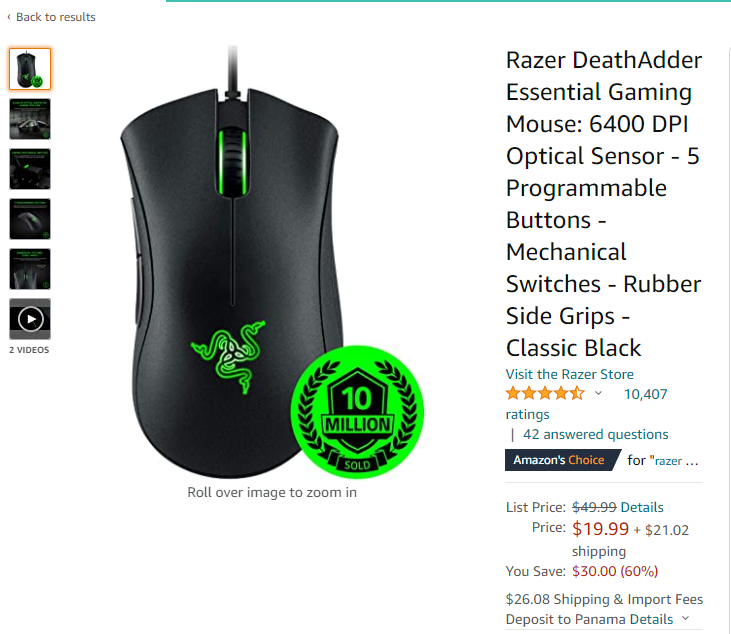

## Amazon Review:

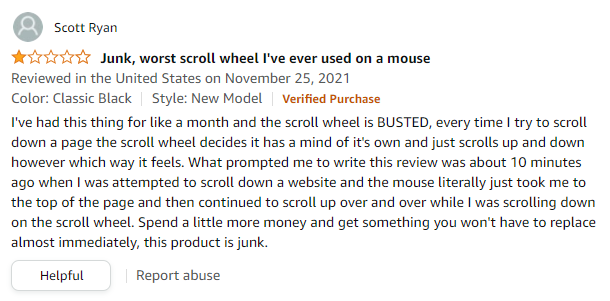

In [120]:
review_title = "Junk, worst scroll wheel I've ever used on a mouse"
review_body = "I've had this thing for like a month and the scroll wheel is BUSTED, every time I try to scroll down a page the scroll wheel decides it has a mind of it's own and just scrolls up and down however which way it feels. What prompted me to write this review was about 10 minutes ago when I was attempted to scroll down a website and the mouse literally just took me to the top of the page and then continued to scroll up over and over while I was scrolling down on the scroll wheel. Spend a little more money and get something you won't have to replace almost immediately, this product is junk."

review = review_title + " " + review_body

predictReviewStars(review)

Input Review: Junk, worst scroll wheel I've ever used on a mouse I've had this thing for like a month and the scroll wheel is BUSTED, every time I try to scroll down a page the scroll wheel decides it has a mind of it's own and just scrolls up and down however which way it feels. What prompted me to write this review was about 10 minutes ago when I was attempted to scroll down a website and the mouse literally just took me to the top of the page and then continued to scroll up over and over while I was scrolling down on the scroll wheel. Spend a little more money and get something you won't have to replace almost immediately, this product is junk.
Predicted Stars: [1.]


## Amazon Review:

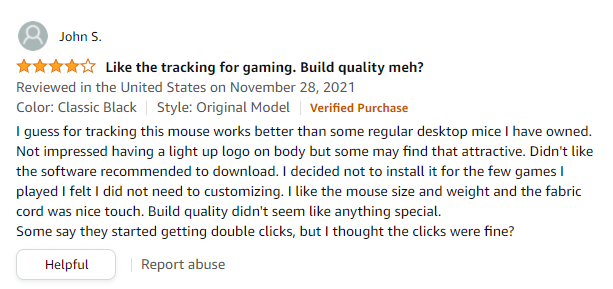

In [121]:
review_title = "Like the tracking for gaming. Build quality meh?"
review_body = "I guess for tracking this mouse works better than some regular desktop mice I have owned. Not impressed having a light up logo on body but some may find that attractive. Didn't like the software recommended to download. I decided not to install it for the few games I played I felt I did not need to customizing. I like the mouse size and weight and the fabric cord was nice touch. Build quality didn't seem like anything special. Some say they started getting double clicks, but I thought the clicks were fine?"
review = review_title + " " + review_body

predictReviewStars(review)

Input Review: Like the tracking for gaming. Build quality meh? I guess for tracking this mouse works better than some regular desktop mice I have owned. Not impressed having a light up logo on body but some may find that attractive. Didn't like the software recommended to download. I decided not to install it for the few games I played I felt I did not need to customizing. I like the mouse size and weight and the fabric cord was nice touch. Build quality didn't seem like anything special. Some say they started getting double clicks, but I thought the clicks were fine?
Predicted Stars: [3.]


## Blog Post
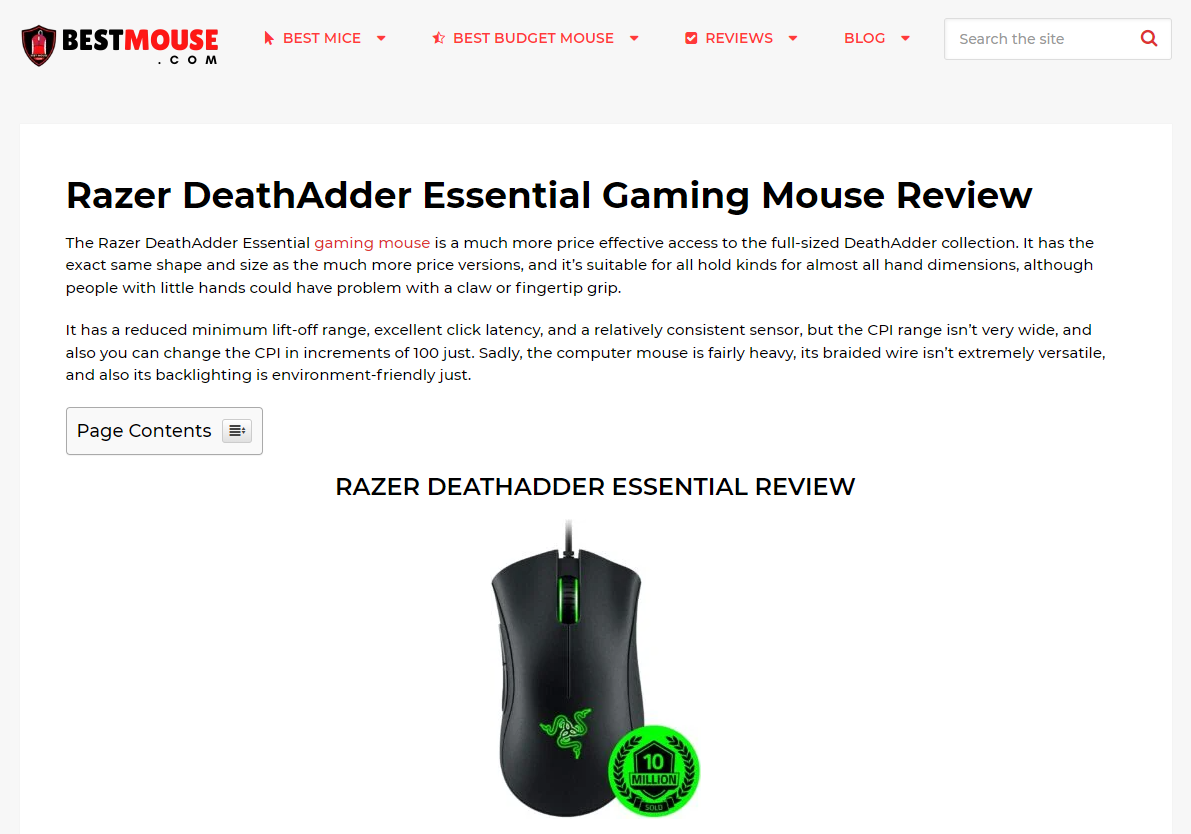

Link: https://best-mouse.com/razer-deathadder-essential-review/

In [122]:
review_title = "Razer DeathAdder Essential Gaming Mouse Review"
review_body = """
The Razer DeathAdder Essential gaming mouse is a much more price effective access to the full-sized DeathAdder collection. It has the exact same shape and size as the much more price versions, and it’s suitable for all hold kinds for almost all hand dimensions, although people with little hands could have problem with a claw or fingertip grip.
It has a reduced minimum lift-off range, excellent click latency, and a relatively consistent sensor, but the CPI range isn’t very wide, and also you can change the CPI in increments of 100 just. Sadly, the computer mouse is fairly heavy, its braided wire isn’t extremely versatile, and also its backlighting is environment-friendly just.
The Razer DeathAdder Important is decent for office usage. It really feels sturdy and also is suitable for mostly all hand dimensions with any type of hold kind, but little hands might have problem with a claw or fingertip hold. You can reprogram all of its buttons making use of the Razer Synapse 3 software, which is readily available on Windows just. Regrettably, its scroll wheel does not have any kind of L/R tilt switches, as well as it can not open for free scrolling.
The Razer DeathAdder Essential benefits FPS gaming. It has a low minimum CPI, a reduced lift-off distance, and also great click latency, although it might not feel responsive enough for some gamers. It feels well-built and appropriates for almost all hand sizes using any grip kind, yet people with small hands may have problem with a claw or fingertip grip. Regrettably, it’s rather heavy, and also its cable television isn’t very versatile. Also, you can change the CPI in increments of 100 only.
The Razer DeathAdder Necessary is a great MMO gaming mouse, although it doesn’t have almost as lots of switches as dedicated MMO mice. Nonetheless, you can program all of them, as well as you can likewise set a HyperShift switch to make it possible for a 2nd layer of commands. It has a low minimum lift-off distance as well as excellent click latency, although it may not really feel responsive sufficient for some gamers.
It feels durable as well as comfortable, and also it appropriates for mostly all hand sizes utilizing any type of hold type, although little hands may struggle with a claw or fingertip hold. Sadly, its cord isn’t really adaptable, as well as you can adjust the CPI in increments of 100 only.
The Razer DeathAdder Necessary is a good ultra-light gaming mouse, although it’s much larger than what we typically consider an ultra-light mouse. Nevertheless, this sturdy-feeling version appropriates for the majority of hand sizes with any hold type, however people with small hands may fight with a claw or fingertip grasp. It has PTFE feet which provide a good gliding experience as well as great click latency, although it might not really feel responsive sufficient to some players. Sadly, its cable television isn’t very flexible.
The Razer DeathAdder Necessary is inadequate for traveling given that it’s bulkier than most mice developed for traveling and also likely will not fit in many laptop cases. Likewise, you can only use it with its cable, which may be troublesome in limited spaces like on public transport.
The ballot rate options on the Razer DeathAdder Necessary are 500Hz as well as 1000Hz. The sensor on our unit is fairly constant, but it often tends to overshoot the set CPI a lot more when moving the computer mouse gradually than when relocate quick.
"""
review = review_title + " " + review_body

predictReviewStars(review)

Input Review: Razer DeathAdder Essential Gaming Mouse Review 
The Razer DeathAdder Essential gaming mouse is a much more price effective access to the full-sized DeathAdder collection. It has the exact same shape and size as the much more price versions, and it’s suitable for all hold kinds for almost all hand dimensions, although people with little hands could have problem with a claw or fingertip grip.
It has a reduced minimum lift-off range, excellent click latency, and a relatively consistent sensor, but the CPI range isn’t very wide, and also you can change the CPI in increments of 100 just. Sadly, the computer mouse is fairly heavy, its braided wire isn’t extremely versatile, and also its backlighting is environment-friendly just.
The Razer DeathAdder Important is decent for office usage. It really feels sturdy and also is suitable for mostly all hand dimensions with any type of hold kind, but little hands might have problem with a claw or fingertip hold. You can reprogram all of

## YouTube Comments

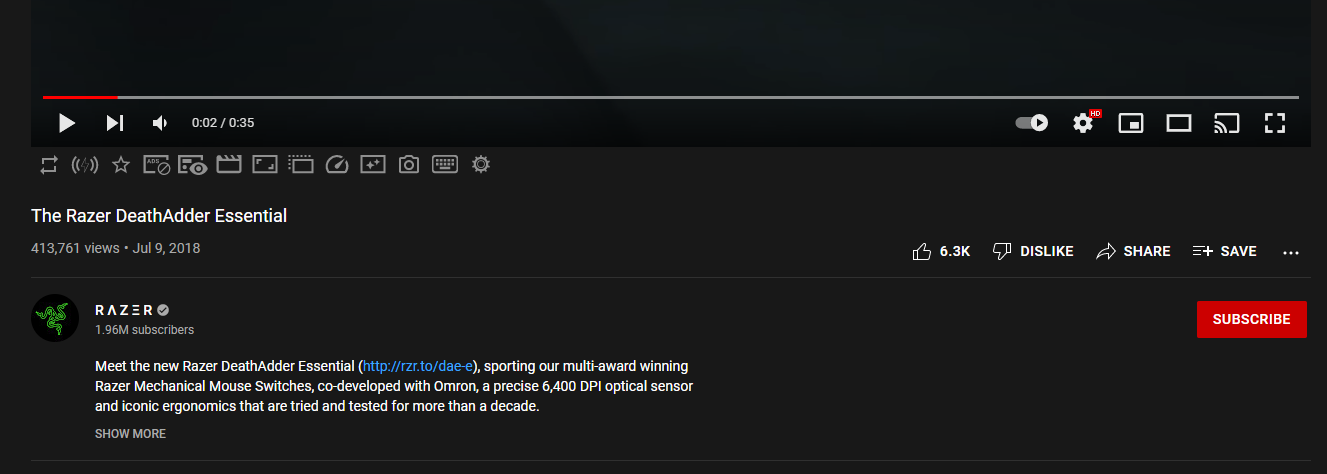

Link: https://www.youtube.com/watch?v=VpCrAJHyvMI

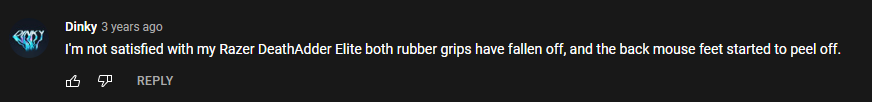

In [124]:
review_title = "The Razer DeathAdder Essential"
review_body = "I'm not satisfied with my Razer DeathAdder Elite both rubber grips have fallen off, and the back mouse feet started to peel off."
review = review_title + " " + review_body

predictReviewStars(review)

Input Review: The Razer DeathAdder Essential I'm not satisfied with my Razer DeathAdder Elite both rubber grips have fallen off, and the back mouse feet started to peel off.
Predicted Stars: [5.]
